In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from scipy.stats import entropy
from statsmodels.graphics.mosaicplot import mosaic




In [27]:
import pandas as pd

def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)

    # Standardize column names
    df.columns = df.columns.str.strip().str.lower()

    if 'salary' not in df.columns:
        raise ValueError("The dataset must contain a 'Salary' column.")

    # Clean Salary column
    df['salary'] = df['salary'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['salary'] = pd.to_numeric(df['salary'], errors='coerce')

    # Drop rows with missing or invalid salary
    df = df.dropna(subset=['salary'])

    # Handle outliers using IQR
    Q1 = df['salary'].quantile(0.25)
    Q3 = df['salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['salary'] >= lower_bound) & (df['salary'] <= upper_bound)]

    df = df.reset_index(drop=True)
    return df


In [28]:
# Feature engineering
def engineer_features(df):
    # Define income groups and assign labels
    def recommend_ev_type(salary):
        if salary >= 800000:
            return '4-wheeler'
        elif salary >= 300000:
            return '3-wheeler'
        else:
            return '2-wheeler'

    df['EV_Type'] = df['Salary'].apply(recommend_ev_type)

    # Encode categorical variables
    le = LabelEncoder()
    df['EV_Label'] = le.fit_transform(df['EV_Type'])  # 0: 2-wheeler, 1: 3-wheeler, 2: 4-wheeler

    # Add other potential features (example - would need actual columns in your data)
    if 'Age' in df.columns:
        df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 40, 60, 100],
                                labels=['18-25', '26-40', '41-60', '60+'])

    return df, le


In [29]:
# Segmentation analysis
def perform_segmentation_analysis(df):
    # K-means clustering
    features = ['Salary']
    if 'Age' in df.columns:
        features.append('Age')
    if 'FamilySize' in df.columns:
        features.append('FamilySize')

    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)



In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def perform_segmentation_analysis(df):
    # Select relevant features
    features = ['Salary']
    if 'Age' in df.columns:
        features.append('Age')
    if 'FamilySize' in df.columns:
        features.append('FamilySize')

    # Scale the features
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow method to find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Based on elbow, choose optimal clusters (you can automate or set manually)
    optimal_clusters = 3  # <-- Change based on elbow plot
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    return df


In [31]:
def perform_segmentation_analysis(df):
    # K-means clustering
    features = ['Salary']
    if 'Age' in df.columns:
        features.append('Age')
    if 'FamilySize' in df.columns:
        features.append('FamilySize')

    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()

    # Apply K-means with selected number of clusters
    optimal_clusters = 3  # Adjust based on elbow plot
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Cluster profiles
    cluster_profile = df.groupby('Cluster').mean()
    print("\nCluster Profiles:")
    print(cluster_profile)

    # PCA visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    df['PC1'] = principal_components[:, 0]
    df['PC2'] = principal_components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis')
    plt.title('PCA Visualization of Clusters')
    plt.show()

    return df, kmeans

In [32]:
# Model training and evaluation
def train_and_evaluate_model(df, le):
    X = df[['Salary']]
    y = df['EV_Label']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Logistic Regression Classifier
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(
        y_test,
        y_pred,
        labels=[0, 1, 2],
        target_names=le.classes_,
        zero_division=0
    ))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Add predictions to dataframe
    df['Predicted_EV_Label'] = model.predict(X)
    df['Predicted_EV_Type'] = le.inverse_transform(df['Predicted_EV_Label'])

    return model

# Visualization
def create_visualizations(df):
    # Actual vs Predicted EV Types
    plt.figure(figsize=(10, 6))
    sns.countplot(x='EV_Type', hue='Predicted_EV_Type', data=df, palette='Set2')
    plt.title("Predicted vs Actual EV Type")
    plt.xlabel("Actual EV Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Salary distribution by cluster
    if 'Cluster' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y='Salary', data=df)
        plt.title("Salary Distribution by Cluster")
        plt.show()

        # Mosaic plot for cluster vs EV type
        crosstab = pd.crosstab(df['Cluster'], df['EV_Type'])
        plt.figure(figsize=(10, 6))
        mosaic(crosstab.stack(), gap=0.01)
        plt.title("Cluster vs EV Type Distribution")
        plt.show()



In [33]:
def perform_segmentation_analysis(df):
    # Select only numeric features for clustering
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Ensure we have at least one numeric feature
    if not numeric_features:
        raise ValueError("No numeric features found for clustering")

    X = df[numeric_features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()

    # Apply K-means with selected number of clusters
    optimal_clusters = 3  # Adjust based on elbow plot
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Cluster profiles - only numeric columns
    cluster_profile = df.groupby('Cluster')[numeric_features].mean()
    print("\nCluster Profiles:")
    print(cluster_profile)

    # PCA visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    df['PC1'] = principal_components[:, 0]
    df['PC2'] = principal_components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis')
    plt.title('PCA Visualization of Clusters')
    plt.show()

    return df, kmeans

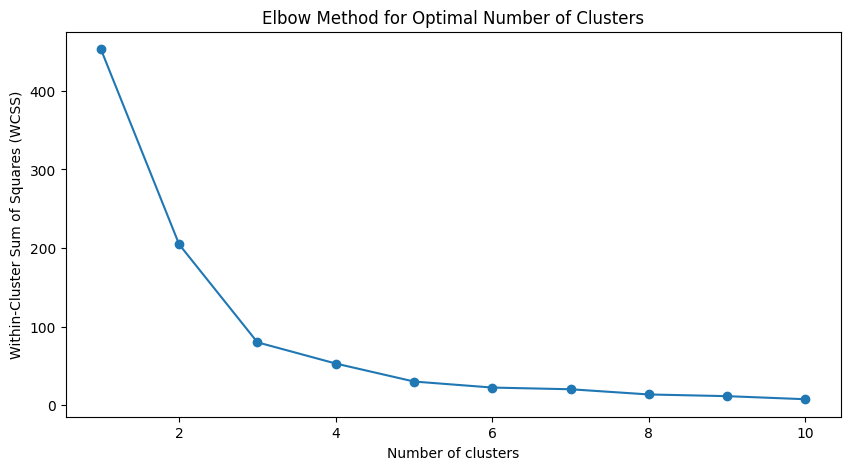


Cluster Profiles:
                salary     resume_id  EV_Label
Cluster                                       
0        446913.793103  1.076237e+08  1.017241
1        137871.794872  1.077524e+08  0.000000
2        295733.333333  4.497206e+07  0.533333


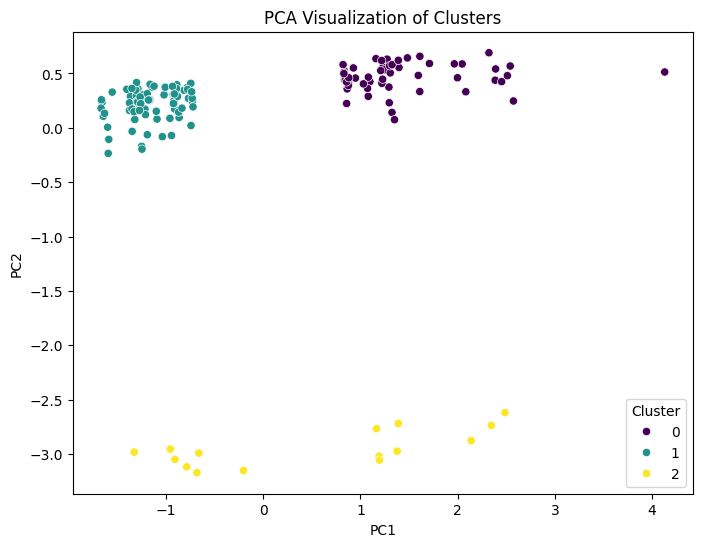

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
              precision    recall  f1-score   support

   2-wheeler       1.00      1.00      1.00        16
   3-wheeler       1.00      1.00      1.00        15
   4-wheeler       0.00      0.00      0.00         0

    accuracy                           1.00        31
   macro avg       0.67      0.67      0.67        31
weighted avg       1.00      1.00      1.00        31


Confusion Matrix:
[[16  0]
 [ 0 15]]


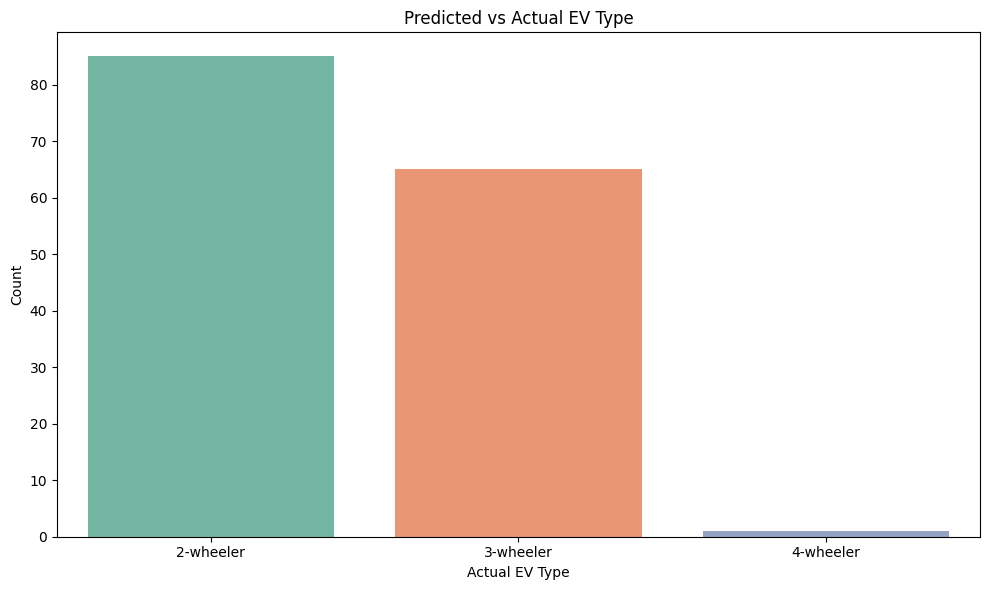

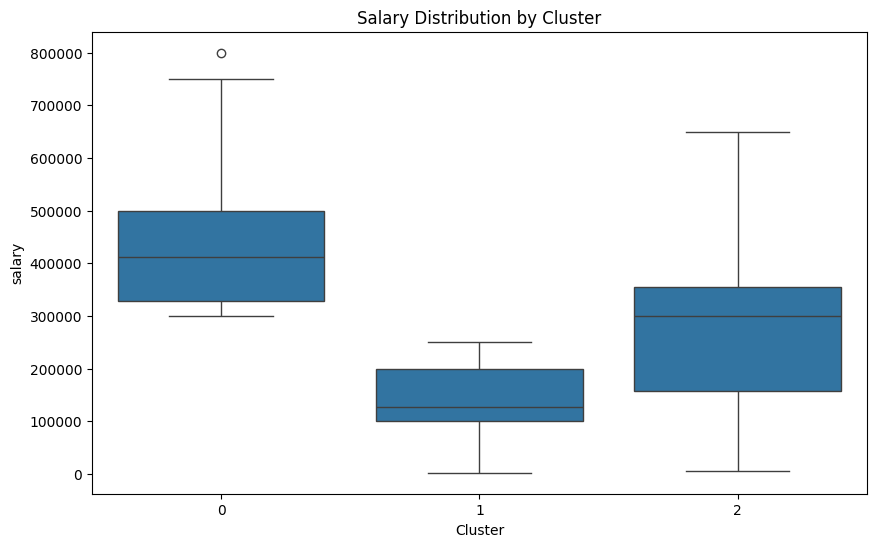

<Figure size 1000x600 with 0 Axes>

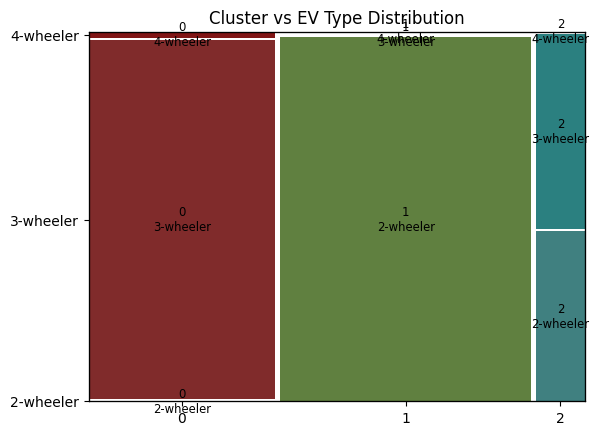

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.graphics.mosaicplot import mosaic

# Load and clean data
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.lower()

    if 'salary' not in df.columns:
        raise ValueError("The dataset must contain a 'Salary' column.")

    df['salary'] = df['salary'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
    df = df.dropna(subset=['salary'])

    Q1 = df['salary'].quantile(0.25)
    Q3 = df['salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['salary'] >= lower_bound) & (df['salary'] <= upper_bound)]

    return df

# Feature engineering
def engineer_features(df):
    def recommend_ev_type(salary):
        if salary >= 800000:
            return '4-wheeler'
        elif salary >= 300000:
            return '3-wheeler'
        else:
            return '2-wheeler'

    df['EV_Type'] = df['salary'].apply(recommend_ev_type)
    le = LabelEncoder()
    df['EV_Label'] = le.fit_transform(df['EV_Type'])

    if 'age' in df.columns:
        df['Age_Group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100],
                                 labels=['18-25', '26-40', '41-60', '60+'])

    return df, le

# Segmentation with KMeans and PCA
def perform_segmentation_analysis(df):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if not numeric_features:
        raise ValueError("No numeric features found for clustering")

    X = df[numeric_features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()

    optimal_clusters = 3
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    cluster_profile = df.groupby('Cluster')[numeric_features].mean()
    print("\nCluster Profiles:")
    print(cluster_profile)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    df['PC1'] = principal_components[:, 0]
    df['PC2'] = principal_components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis')
    plt.title('PCA Visualization of Clusters')
    plt.show()

    return df, kmeans

# Train and evaluate logistic regression model
def train_and_evaluate_model(df, le):
    X = df[['salary']]
    y = df['EV_Label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        labels=[0, 1, 2],
        target_names=le.classes_,
        zero_division=0
    ))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    df['Predicted_EV_Label'] = model.predict(X)
    df['Predicted_EV_Type'] = le.inverse_transform(df['Predicted_EV_Label'])

    return model

# Visualizations
def create_visualizations(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='EV_Type', hue='Predicted_EV_Type', data=df, palette='Set2')
    plt.title("Predicted vs Actual EV Type")
    plt.xlabel("Actual EV Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    if 'Cluster' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y='salary', data=df)
        plt.title("Salary Distribution by Cluster")
        plt.show()

        crosstab = pd.crosstab(df['Cluster'], df['EV_Type'])
        plt.figure(figsize=(10, 6))
        mosaic(crosstab.stack(), gap=0.01)
        plt.title("Cluster vs EV Type Distribution")
        plt.show()

# Main execution
if __name__ == "__main__":
    filepath = "/content/1job-seekers.xlsx - Sheet1.csv"  # Replace with your actual CSV path
    df = load_and_clean_data(filepath)
    df, le = engineer_features(df)
    df, kmeans = perform_segmentation_analysis(df)
    model = train_and_evaluate_model(df, le)
    create_visualizations(df)
